<h1>
    <center>
        Reinforcement learning in TensorFlow

This tutorial can be found [here](https://adventuresinmachinelearning.com/reinforcement-learning-tensorflow)

# The Mountain Car Environment and Open AI Gym

In this reinforcement learning tutorial, the deep Q network that will be created will be trained on the Mountain Car environment/game. This can be accessed through the open source reinforcement learning library called Open AI Gym. A screen capture from the rendered game can be observed below:

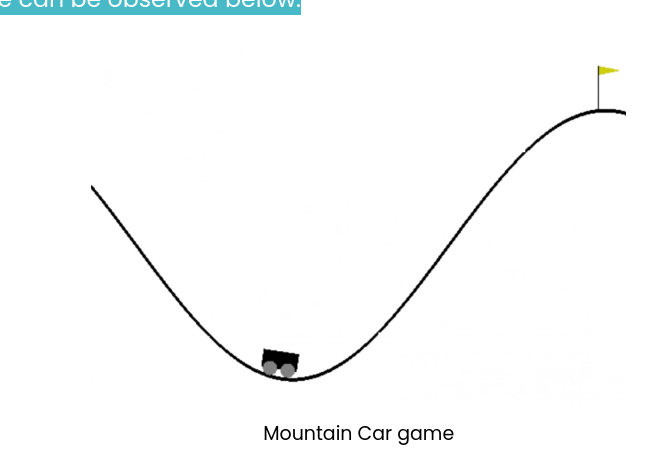

The object of this game is to get the car to go up the right-side hill to get to the flag. There’s one problem however, the car doesn’t have enough power to motor all the way up the hill. Instead, the car / agent needs to learn that it must motor up one hill for a bit, then accelerate down the hill and back up the other side, and repeat until it builds up enough momentum to make it to the top of the hill.

As stated above, Open AI Gym is an open source reinforcement learning package that allows developers to interact easily with games such as the Mountain Car environment. You can find details about the Mountain Car environment here. Basically, the environment is represented by a two-element state vector, detailed below:

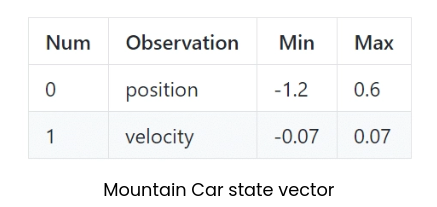

As can be observed, the agent’s state is represented by the car’s position and velocity. The goal/flag is sitting at a position = 0.5. The actions available to the agent are shown below:

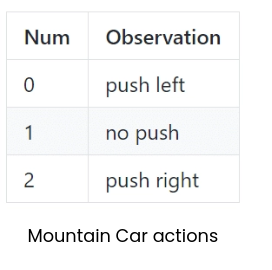

As can be observed, there are three actions available to the agent – accelerate to the left, right and no acceleration.

In the game’s default arrangement, for each time step where the car’s position is <0.5, it receives a reward of -1, up to a maximum of 200 time steps. So the incentive for the agent is to get the car’s position to >0.5 as soon as possible, after which the game ends. This will minimize the negative reward, which is the aim of the game.

However, in this default arrangement, it will take a significant period of time of random exploration before the car stumbles across the positive feedback of getting to the flag. As such, to speed things up a bit, in this example we’ll alter the reward structure to:

*    Position > 0.1, r += 10
*    Position > 0.25 r += 20
*    Position > 0.5 r += 100

This new reward structure gives the agent better positive feedback when it starts learning how to ascend the hill on the right hand side toward the flag. The position of 0.1 is just over half way up the right-hand hill.

# Ok, so now you know the environment, let’s write some code!

In this reinforcement learning implementation in TensorFlow, I’m going to split the code up into three main classes, these classes are:

    Model: This class holds the TensorFlow operations and model definitions
    Memory: This class is where the memory of the actions, rewards and states are stored and retrieved from
    GameRunner: This class is the main training and agent control class

As stated before, I’ll be assuming some prior knowledge of TensorFlow here. If you’re not up to speed your welcome to wing it. Otherwise check out my TensorFlow tutorial. All the code for this tutorial can be found on this site’s Github repository.

I’ll go through each of the classes in turn in the sub-sections below.

# instal libs

* pip install pygame
* pip install gym

# Imports

Import:
* random
* gym
* pyplot
* numpy
* tensorflow

In [1]:
!pip install pygame
!pip install gym

     ---------------------------------------- 8.4/8.4 MB 8.7 MB/s eta 0:00:00
     -------------------------------------- 734.5/734.5 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached importlib_metadata-4.12.0-py3-none-any.whl (21 kB)
  Using cached zipp-3.8.1-py3-none-any.whl (5.6 kB)
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852301 sha256=c66312706671d64e7f376e8c7408278620834a90ab1c084f637be679a40506aa
  Stored in directory: c:\users\callidus\appdata\local\pip\cache\wheels\05\4d\6c\d0ef0db36695ce032fe20099e3149d8db85cf36656176ff745
Successfully built gym


In [3]:
import random
import gym
import matplotlib.pyplot as plt
import numpy as np

C:\Users\callidus\anaconda3\envs\Callidus-Deep-Q\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Initialize the variables

* GAMMA = 0.9 : discount factor
* MIN_EPSILON = 0.01 : Minimum chance of random search
* MAX_EPSILON = 1 : Maximum chance of random search
* LAMBDA = 0.9975  : Decay of random choice
* BATCH_SIZE = 32 : Size of the batch

# The Model Class

The first function within the class is of course the initialization function. All you need to pass into the Model definition is the number of states of the environment (2 in this game), the number of possible actions (3 in this game) and the batch size. The function simply sets up a few internal variables and operations, some of which are exposed as public properties later in the class definition. At the end of the initialization, the second method displayed above _define_model() is called. This method sets up the model structure and the main operations.

* class Model:
*    def __init__(self, num_states, num_actions, batch_size):
*        self._num_states = num_states
*        self._num_actions = num_actions
*        self._batch_size = batch_size
*        \# define the placeholders
*        self._states = None
*        self._actions = None
*        \# the output operations
*        self._logits = None
*        self._optimizer = None
*        self._var_init = None
*        \# now setup the model
*        self._define_model()

First, two placeholders are created _states and _q_s_a – these hold the state data and the $Q(s,a)$ training data respectively. The first dimension of these placeholders is set to None, so that it will automatically adapt when a batch of training data is fed into the model and also when single predictions from the model are required. The next lines create two fully connected layers fc1 and fc2 using the handy TensorFlow layers module. These hidden layers have 50 nodes each, and they are activated using the ReLU activation function (if you want to know more about the ReLU, check out my vanishing gradient and ReLU tutorial).

The next layer is the output layer _logits – this is another fully connected or dense layer, but with no activation supplied. When no activation function is supplied to the dense layer API in TensorFlow, it defaults to a ‘linear’ activation i.e. no activation. This is what we want, as we want the network to learn continuous $Q(s,a)$ values across all possible real numbers.

Next comes the loss – this isn’t a classification problem, so a good loss to use is simply a mean squared error loss. The next line specifies the optimizer – in this example, we’ll just use the generic Adam optimizer. Finally, the TensorFlow boiler plate global variable initializer operation is assigned to _var_init.

*    def _define_model(self):
*        self._states = tf.compat.v1.placeholder(shape=[None, self._num_states], dtype=tf.float32)
*        self._q_s_a = tf.compat.v1.placeholder(shape=[None, self._num_actions], dtype=tf.float32)
*        \# create a couple of fully connected hidden layers
*        fc1 = tf.compat.v1.layers.dense(self._states, 50, activation=tf.nn.relu)
*        fc2 = tf.compat.v1.layers.dense(fc1, 50, activation=tf.nn.relu)
*        self._logits = tf.compat.v1.layers.dense(fc2, self._num_actions)
*        loss = tf.compat.v1.losses.mean_squared_error(self._q_s_a, self._logits)
*        self._optimizer = tf.compat.v1.train.AdamOptimizer().minimize(loss)
*        self._var_init = tf.compat.v1.global_variables_initializer()


So far so good. Next, some methods of the Model class are created to perform prediction and training:

The first method predict_one simply returns the output of the network (i.e. by calling the _logits operation) with an input of a single state. Note the reshaping operation that is used to ensure that the data has a size (1, num_states). This is called whenever action selection by the agent is required. The next method, predict_batch predicts a whole batch of outputs when given a whole bunch of input states – this is used to perform batch evaluation of $Q(s,a)$ and $Q(s’,a’)$ values for training. Finally, there is a method called train_batch which takes a batch training step of the network.

That’s the Model class, now it is time to consider the Memory class.

* def predict_one(self, state, sess):
    *        return sess.run(self._logits, feed_dict={self._states:       state.reshape(1,self.num_states)})
*    def predict_batch(self, states, sess):
    *        return sess.run(self._logits, feed_dict={self._states: states})
*    def train_batch(self, sess, x_batch, y_batch):
    *        sess.run(self._optimizer, feed_dict={self._states: x_batch, self._q_s_a: y_batch})

# Memory
The next class to consider in the code is the Memory class – this class stores all the results of the action of the agent in the game, and also handles the retrieval. These can be used to batch train the network.

First, when the Memory class is initialized, it is necessary to supply a maximum memory argument – this will control the maximum number of (state, action, reward, next_state) tuples the _samples list can hold. The bigger the better, as it ensures better random mixing of the samples, but you have to make sure you don’t run into memory errors.

The first method, add_sample takes an individual (state, action, reward, next_state) tuple and appends it to the _samples list. After this, a check is made – if the number of samples is now larger than the allowable memory size, the first element in _samples is removed using the Python .pop() list functionality.

The final method, sample returns a random selection of no_samples in length. However, if the no_samples argument is larger than the actual memory, whatever is available in the memory is returned.

The final class is called GameRunner.

* class Memory:
*    def __init__(self, max_memory):
*        self._max_memory = max_memory
*        self._samples = []

*    def add_sample(self, sample):
*        self._samples.append(sample)
*        if len(self._samples) > self._max_memory:
*            self._samples.pop(0)

*    def sample(self, no_samples):
*        if no_samples > len(self._samples):
*            return random.sample(self._samples, len(self._samples))
*        else:
*            return random.sample(self._samples, no_samples)

The GameRunner class in this example is where all the model dynamics, agent action and training is organised.

* class GameRunner:
*    def __init__(self, sess, model, env, memory, max_eps, min_eps,
*                 decay, render=True):
*        self._sess = sess
*        self._env = env
*        self._model = model
*        self._memory = memory
*        self._render = render
*        self._max_eps = max_eps
*        self._min_eps = min_eps
*        self._decay = decay
*        self._eps = self._max_eps
*        self._steps = 0
*        self._reward_store = []
*        self._max_x_store = []

In the GameRunner initialization, some internal variables are created. Note, it takes as first argument a TensorFlow session object, then a neural network Model, an Open AI gym environment and a Memory class instance. The next arguments max_eps and min_eps dictate the maximum and minimum epsilon values respectively – during training the actual $\epsilon$ will decay from the maximum to the minimum based on the following argument decay. Finally, render is a boolean which determines whether the game environment is rendered to the screen.

The next method is run():

*    def run(self):
*        state = self._env.reset()
*        tot_reward = 0
*        max_x = -100
*        while True:
*            if self._render:
*                self._env.render()

*            action = self._choose_action(state)
*            next_state, reward, done, info = self._env.step(action)
*            if next_state[0] >= 0.1:
*                reward += 10
*            elif next_state[0] >= 0.25:
*                reward += 20
*            elif next_state[0] >= 0.5:
*                reward += 100

*            if next_state[0] > max_x:
*                max_x = next_state[0]
*            \# is the game complete? If so, set the next state to
*            \# None for storage sake
*            if done:
*                next_state = None

*            self._memory.add_sample((state, action, reward, next_state))
*            self._replay()

*            \# exponentially decay the eps value
*            self._steps += 1
*            self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) \
*                        * np.math.exp(-LAMBDA * self._steps)

*            \# move the agent to the next state and accumulate the reward
*            state = next_state
*            tot_reward += reward

*            \# if the game is done, break the loop
*            if done:
*                self._reward_store.append(tot_reward)
*                self._max_x_store.append(max_x)
*                break

*        print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))


We’ll go through each step in the code above. First, the environment is reset by calling the Open AI Gym command .reset(). Then an infinite loop is entered into – this will be exited by calling a break command. If the boolean _render is True, then the output of the game will be shown on the screen. The action of the agent is determined by calling the internal method _choose_action(state) – this will discussed later. Next, the agent takes action by calling the Open AI Gym command step(action). This command returns a tuple containing the new state of the agent, the reward received by taking action, a done boolean indicating whether the game has finished, and an information object (we won’t using info in this example).

The next step in the code is where there are some manual adjustments to the Mountain Car reward system. If you recall, earlier I mentioned that in order to speed up the training of the network, it was useful to add some more reward steps the closer the car got to the goal (rather than the default reward which was only received when the car reached the goal/flag). The maximum x value achieved in the given episode is also tracked and this will be stored once the game is complete.

The next step is a check to see if the game has completed i.e. done == True – this will occur after 200 turns. If it has completed, we want to set the next_state to None. This will be picked up during the training / replay step of the class, and the state will be set to an array of zeros whenever next_state is equal to None.

After this, the data about the agent is stored in the memory class – i.e.its original state, its chosen action, the reward it received for that action and finally the next_state of the agent. After this takes place, the training / replay step of the deep Q network is run – this step will be discussed more below. At this point the epsilon value is also exponentially decayed. Finally, the agent’s state is moved to next_state, the total reward during the game is accumulated, and there is some printing and breaking of the loop and storing of relevant variables if the game is complete.

The next part of the GameRunner class is the agent action selection method:


* def _choose_action(self, state):
*        if random.random() < self._eps:
*            return random.randint(0, self._model.num_actions - 1)
*        else:
*            return np.argmax(self._model.predict_one(state, self._sess))

This method executes our epsilon greedy + Q policy. In the first case, if a random number is less than the _eps value, then the returned action will simply be an action chosen at random from the set of possible actions. Otherwise, the action will be chosen based on an argmax of the output from the neural network. Recall that _predict_one from the model will take a single state as input, then output $Q(s,a)$ values for each of the possible actions available – the action with the highest $Q(s,a)$ value is that action with the highest expected current + future discounted reward.

The final method within the GameRunner class is the _replay method, where the batching and training takes place:

*   def _replay(self):
*        batch = self._memory.sample(self._model.batch_size)
*        states = np.array([val[0] for val in batch])
*        next_states = np.array([(np.zeros(self._model.num_states)
*                                 if val[3] is None else val[3]) for val * in batch])
*        \# predict Q(s,a) given the batch of states
*        q_s_a = self._model.predict_batch(states, self._sess)
*        \# predict Q(s',a') - so that we can do gamma * max(Q(s'a')) below
*        q_s_a_d = self._model.predict_batch(next_states, self._sess)
*        \# setup training arrays
*        x = np.zeros((len(batch), self._model.num_states))
*        y = np.zeros((len(batch), self._model.num_actions))
*        for i, b in enumerate(batch):
*            state, action, reward, next_state = b[0], b[1], b[2], b[3]
*            \# get the current q values for all actions in state
*            current_q = q_s_a[i]
*            \# update the q value for action
*            if next_state is None:
*                \# in this case, the game completed after action, so there is no max Q(s',a')
*                \# prediction possible
*                current_q[action] = reward
*            else:
*                current_q[action] = reward + GAMMA * np.amax(q_s_a_d[i])
*            x[i] = state
*            y[i] = current_q
*        self._model.train_batch(self._sess, x, y)

The first step in the _replay method is to retrieve a randomized batch of data from memory. Next, we want to setup our batch state variables so that we can:

    For each state, produce baseline $Q(s,a)$ values – one of which will be given a target of $r + \gamma \max_{a’} Q(s’, a’)$
     For each next_state, predict $Q(s’,a’)$ from the model, as required in (1)

Now, if you recall, each sample in memory has the form of a tuple: state, action, reward, next_state which was extracted from the game play. To setup a batch of initial states, then, we simply use Python list comprehension to extract the first tuple value from each sample in the batch. Likewise, we do the same for the fourth value in the tuple to extract the next_state value for each sample in the batch. Note that whenever the next_state corresponds to a case where the game finished (i.e. next_state is None) the next state value is replaced by a vector of zeros corresponding in size to the number of states in the game.

Next, the batch of $Q(s, a)$ and $Q(s’,a’)$ values are extracted from the model from states and next_states respectively. The x and y training arrays are then created, but initially filled with zeros. After this, a loop is entered into to accumulate the x and y values on which to train the model. Within this loop, we extract the memory values from the batch, then set a variable designating the Q values for the current state. If the next_state value is actually zero, there is no discounted future rewards to add, so the current_q corresponding to action is set a target of the reward only. Alternatively, if there is a valid next_state, then the current_q corresponding to action is set a target of the reward plus the discounted future reward i.e. $max_{a’} Q(s’, a’)$.

The state and current_q are then loaded into the x and y values for the given batch, until the batch data is completely extracted. Then the network is trained by calling _train_batch() on the model.

That completes the review of the main classes within the TensorFlow reinforcement learning example. All that is left is to setup the classes and enter the training loop.

# The main function

The code below sets up the environment and the classes, and runs multiple games to perform the learning:

In the first couple of lines, we create an Open AI Gym Mountain Car environment. Next, the number of states and actions are extracted from the environment object itself.

The network model and memory objects are then created – in this case, we’re using a batch size of 50 and a total number of samples in the memory of 50,000.

The TensorFlow session object is created, along with the variable initialization – then the GameRunner class is created. The number of episodes of the Mountain Car game which will be run in this training example is 300. For each of these episodes, we run the game by using the GameRunner run() method.

After all the episodes are run, some plotting is performed on the total reward for each episode, and the maximum x-axis value the cart reaches in the game (remembering that the goal is at x = 0.5)